In [1]:
from pydrake.all import StartMeshcat, MeshcatVisualizer, AddMultibodyPlantSceneGraph, HalfSpace, CoulombFriction, MeshcatVisualizerParams, ConstantValueSource, LogVectorOutput
import matplotlib.pyplot as plt, numpy as np, datetime, pydot, os, logging, pickle
from pydrake.math import RigidTransform
from pydrake.all import DiagramBuilder, Simulator, Parser
from direct_col_dev import dir_col
from phase_switch import *
from osc import *
from pydrake.systems.planar_scenegraph_visualizer import (ConnectPlanarSceneGraphVisualizer)
from pydrake.geometry import Box

runstart = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
file_name = None

if not 'src' in os.getcwd():
    for (root, dir, files) in os.walk(os.getcwd()):
        if 'src' in dir:
            os.chdir(os.path.join(root, 'src'))
            break

folders = ['./logs', './report', f'./logs/{runstart}']
for folder in folders:
    if not os.path.exists(folder):
        os.mkdir(folder)

logging.basicConfig(filename=f'./logs/{runstart}/Messages.log', level=logging.DEBUG, format='%(asctime)s -  %(name)s - %(levelname)s - %(message)s')
logging.getLogger("matplotlib").setLevel(logging.CRITICAL)
logging.getLogger("DIRCOL").setLevel(logging.DEBUG)

for root, dirs, files in os.walk('../'):
      for file in files:
          if "planar_walker.urdf" in file:
              file_name = os.path.join(root, file)

# DIRCOL Parameters #
N = 5
jump_height = 0.5
tf = 1/2

# Robot Parameters #
initial_state = np.zeros(14)
q = np.zeros((7,))
q[0] = 0; q[1] = 0.95
theta = -np.arccos(q[1])
q[3] = theta; q[4] = -2 * theta
q[5] = theta;   q[6] = -2 * theta
initial_state[:7] = q

logging.debug(f"Initial state at {q.round(3)}")
logging.debug(f"Jump Height: {jump_height}, tf: {tf}, {N} knot points")

### Designing the Simulator environment ###
meshcat = StartMeshcat()
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.0005)
X_WG = HalfSpace.MakePose(np.array([0.1,0, 1]), np.zeros(3,))
plant.RegisterCollisionGeometry(plant.world_body(), X_WG, HalfSpace(), "collision", CoulombFriction(1.0, 1.0))
#Make a Geometry of Box shape (Doesnt work with half Space)
plant.RegisterVisualGeometry(plant.world_body(),X_WG,Box(100, 2, 0.001),"ground_visual",np.array([1.0,0.1,0.1,0.1]))


parser = Parser(plant)
sim_file = "/home/anirudhkailaje/Documents/01_UPenn/02_MEAM5170/03_FinalProject/models/planar_walker.urdf"
logging.debug(f"Using Sim urdf: {sim_file}")
parser.AddModels(sim_file)
plant.WeldFrames(plant.world_frame(),
    plant.GetBodyByName("base").body_frame(),
    RigidTransform.Identity())
plant.Finalize()

### Direct Collocation ###
n_q = plant.num_positions()
n_v = plant.num_velocities()
n_u = plant.num_actuators()
x_traj, u_traj, prog,  x_sol, u_sol = dir_col(N, initial_state, jump_height, tf=tf, jumpheight_tol=5e-2)
np.save(os.path.join(folders[-1], "x_sol.npy"),x_sol)
np.save(os.path.join(folders[-1], "u_sol.npy"),u_sol)

logging.debug("Direct Collocation Completed")

optimal cost: 254717.39132848498
x_sol: [[-0.000e+00  9.500e-01 -0.000e+00 -3.200e-01  6.400e-01 -3.200e-01
   6.400e-01  0.000e+00 -0.000e+00  0.000e+00 -0.000e+00 -0.000e+00
   0.000e+00 -0.000e+00]
 [ 0.000e+00  8.400e-01  0.000e+00 -4.900e-01  3.200e-01 -2.700e-01
   1.600e-01  1.000e-02  2.600e-01  3.600e-01  5.770e+00 -5.492e+01
   6.730e+00 -3.570e+01]
 [-0.000e+00  8.200e-01 -0.000e+00 -1.270e+00  3.500e-01 -9.500e-01
   1.030e+00  1.000e-02 -1.000e-02  6.100e-01 -4.870e+00  4.710e+00
   1.600e-01  8.700e-01]
 [ 0.000e+00  8.200e-01 -0.000e+00 -1.530e+00  6.400e-01 -9.000e-01
   5.600e-01 -4.600e-01 -2.000e-01 -1.280e+00 -7.500e+00  4.900e+00
  -1.954e+01  2.662e+01]
 [-1.000e-02  5.800e-01  4.000e-02 -6.700e-01  7.400e-01 -3.900e-01
   3.600e-01  1.120e+00  3.120e+00  7.830e+00  2.807e+01  8.493e+01
   2.687e+01 -4.900e+00]]
u_sol: [[ -15.   80.  -98.  -47.]
 [ -14.  -37.   17.    6.]
 [  19.   49.   -5.    0.]
 [ -60. -108.  -25.  -10.]
 [ 302.  429.   94.   57.]]
Required Ve

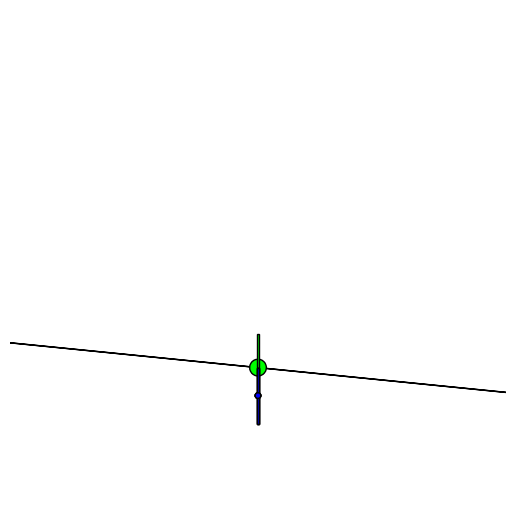

In [2]:
OSC_Accesor = OSC(file_name, u_traj)
logging.getLogger("OSC").setLevel(logging.DEBUG)
PhaseSwitcher = builder.AddSystem(PhaseSwitch(jump_height, tf, x_traj, 0.7, file_name))
OScontroller = builder.AddSystem(OSC_Accesor)
logger = LogVectorOutput(OScontroller.GetOutputPort("logs"),builder)
builder.Connect(PhaseSwitcher.get_preflight_port_index(),OScontroller.get_preflightinput_port_index())
builder.Connect(PhaseSwitcher.get_aerial_trajectory_port_index(),OScontroller.get_flightinput_port_index())
builder.Connect(PhaseSwitcher.get_landing_trajectory_port_index(),OScontroller.get_landinginput_port_index())
builder.Connect(PhaseSwitcher.get_phase_switch_output_port_index(),OScontroller.get_phase_port_index())
builder.Connect(OScontroller.torque_output_port, plant.get_actuation_input_port())
builder.Connect(plant.get_state_output_port(), OScontroller.get_state_input_port()) 
builder.Connect(plant.get_state_output_port(), PhaseSwitcher.get_state_input_port()) 

# GIF Generators
T_VW = np.array([[1., 0., 0., 0.],
                    [0., 0., 1., 0.],
                    [0., 0., 0., 1.]])
visualizer = ConnectPlanarSceneGraphVisualizer(builder, scene_graph, T_VW=T_VW, xlim=[-2.2, 2.2],ylim=[-1.2, 3.2])



#Builld
vis_params = MeshcatVisualizerParams(publish_period=0.01)
MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat, params=vis_params)
diagram = builder.Build()

/home/anirudhkailaje/.local/lib/python3.11/site-packages/pydrake/systems/pyplot_visualizer.py:86: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


(1000, 3)


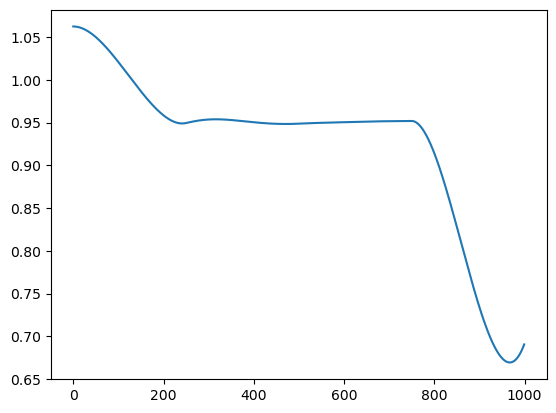

In [3]:
### Real Time Simulation ###
sim_time = tf+3
simulator = Simulator(diagram)
simulator.Initialize(); 
plant_context = diagram.GetMutableSubsystemContext(plant, simulator.get_mutable_context())
graph = (pydot.graph_from_dot_data(diagram.GetGraphvizString(max_depth=2))[0].create_svg())
with open('graph.svg', 'wb') as f:
    f.write(graph)

timesteps = np.linspace(0, tf, 1000)
com_pos_list = []
vel_list = []
for t in timesteps:
  x = x_traj.vector_values([t])
  u = u_traj.vector_values([t])
  plant.SetPositionsAndVelocities(plant_context, x)
  com_pos = plant.CalcCenterOfMassPositionInWorld(plant_context).ravel()
  com_pos_list.append(com_pos)

np.save('com.npy', np.array(com_pos_list))
print(np.array(com_pos_list).shape)
traj = np.array(com_pos_list)
# plt.plot(traj[:,0])
# plt.plot(traj[:,1])
plt.plot(traj[:,2])
# plt.plot(traj[:,3])

In [4]:
### Go ###
sim_time = tf+3
simulator = Simulator(diagram)
simulator.Initialize(); simulator.set_target_realtime_rate(1.0)
plant_context = diagram.GetMutableSubsystemContext(plant, simulator.get_mutable_context())
plant.SetPositionsAndVelocities(plant_context, initial_state)
visualizer.start_recording()
simulator.AdvanceTo(sim_time)
visualizer.stop_recording()
ani = visualizer.get_recording_as_animation()
ani.save(f"./logs/{runstart}/result.gif", fps=30)

/home/anirudhkailaje/.local/lib/python3.11/site-packages/pydrake/systems/pyplot_visualizer.py:86: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


In [ ]:
%matplotlib widget
log = logger.FindLog(simulator.get_mutable_context()) 
t = log.sample_times()[1:]
x = log.data()[:,1:]
COM_POS, COM_VEL, T_POS, T_VEL, left, right, COM_POS_DESIRED, COM_VEL_DESIRED, Torso_POS_DESIRED, Torso_VEL_DESIRED, LFt_POS_DESIRED, RFt_POS_DESIRED, FSM, Torque, Costs,LeftContactForces, RightContactForces  =  OSC_Accesor.logParse(x)


with open(f"./logs/{runstart}/data.pickle", 'wb') as f:
    data = [COM_POS, COM_VEL, T_POS, T_VEL, left, right, COM_POS_DESIRED, COM_VEL_DESIRED, Torso_POS_DESIRED, Torso_VEL_DESIRED, LFt_POS_DESIRED, RFt_POS_DESIRED, FSM, Torque, Costs, t, LeftContactForces, RightContactForces]
    for i, datum in enumerate(data):
        data[i] = np.float32(datum.round(3))
    pickle.dump(tuple(data), f)

logging.debug(f"Saved data at: {f'./logs/{runstart}/data.pickle'}")
FSM = np.int32(FSM)
colors = ['skyblue', 'lightcoral', 'lightgreen']
# Find boundaries where the finite state changes
boundaries = np.where(np.diff(FSM[0, :]) != 0)[0]
boundaries = np.concatenate([[0], boundaries, [len(t)-1]])


# Function to create subplots for 3D data
def plot_3d_data(ax, t, data, label, linestyle='-', alpha=0.1):
    ax.plot(t, data[0, :], label=f'{label} - X', linestyle=linestyle, color='C0')
    ax.plot(t, data[1, :], label=f'{label} - Y', linestyle=linestyle, color='C1')
    ax.plot(t, data[2, :], label=f'{label} - Z', linestyle=linestyle, color='C2')

    ## Color Coding ##
    for i in range(0, len(boundaries)-1):
        start_idx, end_idx = boundaries[i]+1, boundaries[i+1]
        ax.axvspan(t[start_idx], t[end_idx], color=colors[FSM[0, start_idx]], alpha=alpha, lw=0)

# Create subplots
fig, axs = plt.subplots(10, 1, figsize=(7, 20))

# Plotting each pair of actual and desired values
plot_3d_data(axs[0], t, COM_POS, 'COM_POS', alpha=0.1)
plot_3d_data(axs[0], t, COM_POS_DESIRED, 'COM_POS_DESIRED', '--', alpha=0.1)
axs[0].set_title('Center of Mass Position')
axs[0].legend(loc='upper right')

plot_3d_data(axs[1], t, COM_VEL, 'COM_POS', alpha=0.1)
plot_3d_data(axs[1], t, COM_VEL_DESIRED, 'COM_POS_DESIRED', '--', alpha=0.1)
axs[1].set_title('Center of Mass Velocity')
axs[1].legend(loc='upper right')

axs[2].plot(t, T_POS[0], label = 'T_POS', color='C0')
axs[2].plot(t, Torso_POS_DESIRED[0], label='Torso_POS_DESIRED', linestyle='--', color='C1')
for i in range(0, len(boundaries)-1):
    start_idx, end_idx = boundaries[i]+1, boundaries[i+1]
    axs[2].axvspan(t[start_idx], t[end_idx], color=colors[FSM[0, start_idx]], alpha=0.1, lw=0)
axs[2].set_title('Torso Position')
axs[2].legend(loc='upper right')

axs[3].plot(t, T_VEL[0], label='T_VEL', color='C0')
axs[3].plot(t, Torso_VEL_DESIRED[0], label='Torso_VEL_DESIRED', linestyle='--', color='C1')
for i in range(0, len(boundaries)-1):
    start_idx, end_idx = boundaries[i]+1, boundaries[i+1]
    axs[3].axvspan(t[start_idx], t[end_idx], color=colors[FSM[0, start_idx]], alpha=0.1, lw=0)
axs[3].set_title('Torso Velocity')
axs[3].legend(loc='upper right')

plot_3d_data(axs[4], t, left, 'Left', alpha=0.1)
plot_3d_data(axs[4], t, LFt_POS_DESIRED, 'Ft_POS_DESIRED', '--', alpha=0.1)
axs[4].set_title('Left and Desired Foot Position')
axs[4].legend(loc='upper right')

plot_3d_data(axs[5], t, right, 'Right', alpha=0.1)
plot_3d_data(axs[5], t, RFt_POS_DESIRED, 'Ft_POS_DESIRED', '--', alpha=0.1)
axs[5].set_title('Right and Desired Foot Position')
axs[5].legend(loc='upper right')


axs[6].semilogy(t, Costs[0], label='Cost', color='C0')
for i in range(0, len(boundaries)-1):
    start_idx, end_idx = boundaries[i]+1, boundaries[i+1]
    axs[6].axvspan(t[start_idx], t[end_idx], color=colors[FSM[0, start_idx]], alpha=0.1, lw=0)
axs[6].set_title('Optimal Costs')
axs[6].legend(loc='upper right')


axs[7].plot(t, Torque[0,:], label='T1', color='C0')
axs[7].plot(t, Torque[1,:], label='T2', color='C1')
axs[7].plot(t, Torque[2,:], label='T3', color='C2')
axs[7].plot(t, Torque[3,:], label='T4', color='C3')
for i in range(0, len(boundaries)-1):
    start_idx, end_idx = boundaries[i]+1, boundaries[i+1]
    axs[7].axvspan(t[start_idx], t[end_idx], color=colors[FSM[0, start_idx]], alpha=0.1, lw=0)
axs[7].set_title('Torques')
axs[7].legend(loc='upper right')

plot_3d_data(axs[8], t, LeftContactForces, 'Left Contact Forces', alpha=1)
axs[8].set_title('Left Contact Forces')
plot_3d_data(axs[9], t, RightContactForces, 'Right Contact Forces', alpha=1)
axs[9].set_title('Right Contact Forces')


# Set common labels and title
fig.text(0.5, 0.04, 'Time', ha='center', va='center')
fig.text(0.06, 0.5, 'Position', ha='center', va='center', rotation='vertical')
fig.suptitle('Performance', fontsize=16)

plt.tight_layout()
plt.show()


In [ ]:
COM_POS.max()